### This vignette demonstrates how the probablistic spatial sampling routine works

First, we will load the necessary packages to run the code

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# Author: Lewis Kunik - University of Utah
# Contact: lewis.kunik@utah.edu
#

#%%
#########################################
# Load packages
#########################################

# File system packages
import os  # operating system library
import sys
import glob
from pathlib import Path
import copy

# numerical/data management packages
import numpy as np
import xarray as xr 
import pandas as pd

# shapefile/geospatial packages
import geopandas as gpd
from shapely.geometry import mapping
from shapely.geometry import Point

# time and date packages
import time
from datetime import datetime as dt  # date time library
from datetime import timedelta

# Standard plotting packages
from matplotlib import pyplot as plt  # primary plotting module
from matplotlib.ticker import FuncFormatter as FFmt  # need this for formatting plot ticks

# Geospatial plotting packages
import cartopy.crs as ccrs  # cartopy is the best spatial plotting library i know
from cartopy.io import img_tiles  # cartopy's implementation of webtiles
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature




Define any global filepaths and variables that will be needed throughout the script 

In [2]:

#########################################
# Define Global Filepaths
#########################################

dat_basedir = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/SIF/SIF_IAV/data/'
EPA_ecoregion_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/EPA/ecoregions/'
EPA_ecoregion_L2_file = os.path.join(EPA_ecoregion_dir, 'L2', 'WUS_cec_eco_l2.shp')

########################################
# Define Global Variables and constants
#########################################

# Define the averaging window definition for "annual" values
timing_label = 'FULL_YEAR' # options: "FULL_YEAR", "TOP_QUARTILE", "POST_PEAK_LAI", "PRE_PEAK_LAI"
dat_dir = os.path.join(dat_basedir, timing_label)  # directory where data files are stored, based on timing_label
analysis_years = range(2018, 2024)

## Define paths to data files
TROPOMI_SIF_file = glob.glob(f'{dat_dir}/TROPOMI_SIF*.nc')[0]


#########################################
# Set plotting parameters
#########################################

plt.rcParams.update({
   'axes.labelsize': 16,
   'axes.titlesize': 16,
   'xtick.labelsize': 16,
   'ytick.labelsize': 15,
   'legend.fontsize': 13,

})

# use Google Satellite imagery as basemap
tiler = img_tiles.GoogleTiles(style='satellite')
crs = tiler.crs # set crs of map tiler
alpha = 0.8  # transparency 0-1
transform = ccrs.PlateCarree()  # transform specifies the crs that the data is in

tiler_zoom = 7  # define a zoom level of detail
extent = [-125.3, -102.7, 29.7, 50.3]  # [minx, maxx, miny, maxy], bounds for map

### Load state boundaries
fn = shpreader.natural_earth(
   resolution='10m', category='cultural', 
   name='admin_1_states_provinces',
)
reader = shpreader.Reader(fn)
states = [x for x in reader.records() if x.attributes["admin"] == "United States of America"] # get all states in US
states_geom = cfeature.ShapelyFeature([x.geometry for x in states], ccrs.PlateCarree())

# matplotlib map plotting functions
def z_axis_formatter(x, pos, deci=2):
   '''Format ticks to format with deci number of decimals'''

   return f'{x:.{deci}f}'


Define any functions that will be needed throughout the script

In [3]:
#########################################
# Define Global Functions
#########################################

# -----------------------------------------------------------------------
# Function to load xarray data and set CRS
# -----------------------------------------------------------------------
def load_xr(dat_xr_file, varname = None):
    if varname is not None:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)[varname]
    else:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)
    dat_xr.rio.write_crs(4326, inplace=True)
    return dat_xr


def xarray_to_long_df(da_dict, response_var_name):
    """
    Convert dictionary of xarray DataArrays to long format DataFrame
    suitable for mixed effects modeling
    """
    # Start with response variable - only keep essential coordinates
    response_da = da_dict[response_var_name]
    df = response_da.to_dataframe(name=response_var_name).reset_index()
    
    # Keep only the columns we need for merging and analysis
    essential_cols = ['x', 'y', response_var_name]
    if 'year' in df.columns:
        essential_cols.append('year')
    
    df = df[essential_cols].dropna(subset=[response_var_name])
    
    # Add explanatory variables one by one
    for var_name, da in da_dict.items():
        if var_name != response_var_name:
            # Convert to dataframe and keep only essential columns
            var_df = da.to_dataframe(name=var_name).reset_index()
            
            # Keep only coordinates and the variable of interest
            var_essential_cols = ['x', 'y', var_name]
            if 'year' in var_df.columns:
                var_essential_cols.append('year')
            
            var_df = var_df[var_essential_cols].dropna(subset=[var_name])
            
            # Handle time-invariant variables (no year dimension)
            if 'year' not in var_df.columns and 'year' in df.columns:
                # Replicate time-invariant data for each year
                years = df['year'].unique()
                var_df_expanded = []
                for year in years:
                    temp_df = var_df.copy()
                    temp_df['year'] = year
                    var_df_expanded.append(temp_df)
                var_df = pd.concat(var_df_expanded, ignore_index=True)
            
            # Determine merge columns
            merge_cols = ['x', 'y']
            if 'year' in var_df.columns:
                merge_cols.append('year')
                
            # Merge with main dataframe
            df = df.merge(var_df, on=merge_cols, how='inner')
    
    return df



def spatial_subsample_grid_probabilistic(df, spacing_deg=1.0, seed=None, verbose=False):
    """
    Subsample pixels by dividing domain into regular grid cells, then:
    1. Count valid pixels in each cell
    2. Sample one random pixel from each cell
    3. Include sampled pixel with probability proportional to cell density
    
    Cells with the most pixels have probability=1.0 (always included)
    Cells with fewer pixels have proportionally lower probability
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with 'x' (longitude) and 'y' (latitude) columns
    spacing_deg : float
        Grid cell size in degrees (e.g., 1.0 for 1° x 1° cells)
    seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    DataFrame with probabilistically subsampled pixels
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Get unique pixel locations
    pixels = df[['pixel_id', 'x', 'y']].drop_duplicates()
    
    # Get domain extent
    x_min, x_max = pixels['x'].min(), pixels['x'].max()
    y_min, y_max = pixels['y'].min(), pixels['y'].max()
    
    # Create grid cell boundaries
    x_bins = np.arange(x_min, x_max + spacing_deg, spacing_deg)
    y_bins = np.arange(y_min, y_max + spacing_deg, spacing_deg)
    
    if verbose:
        print(f"Grid dimensions: {len(x_bins)-1} x {len(y_bins)-1} = {(len(x_bins)-1) * (len(y_bins)-1)} cells")

    # Assign each pixel to a grid cell
    pixels['x_cell'] = np.digitize(pixels['x'], x_bins) - 1
    pixels['y_cell'] = np.digitize(pixels['y'], y_bins) - 1
    pixels['cell_id'] = pixels['x_cell'].astype(str) + '_' + pixels['y_cell'].astype(str)
    
    # Count pixels per cell
    cell_counts = pixels.groupby('cell_id').size()
    max_count = cell_counts.max()
    if verbose:
        print(f"Pixels per cell - Min: {cell_counts.min()}, Max: {max_count}, Mean: {cell_counts.mean():.1f}")
    
    # Calculate probability for each cell (proportional to pixel count)
    cell_probabilities = cell_counts / max_count
    
    selected_pixels = []
    cell_info = []
    
    # For each cell, randomly sample one pixel and decide whether to include it
    for cell_id, cell_group in pixels.groupby('cell_id'):
        n_pixels_in_cell = len(cell_group)
        probability = cell_probabilities[cell_id]
        
        # Randomly select one pixel from this cell
        sampled_pixel = cell_group.sample(n=1, random_state=seed).iloc[0]
        
        # Include this pixel with probability proportional to cell density
        if np.random.random() < probability:
            selected_pixels.append(sampled_pixel['pixel_id'])
            cell_info.append({
                'cell_id': cell_id,
                'n_pixels': n_pixels_in_cell,
                'probability': probability,
                'included': True
            })
        else:
            cell_info.append({
                'cell_id': cell_id,
                'n_pixels': n_pixels_in_cell,
                'probability': probability,
                'included': False
            })
    
    # Create summary dataframe
    cell_summary = pd.DataFrame(cell_info)
    if verbose:
        print(f"\nOriginal pixels: {len(pixels)}")
        print(f"Grid cells with data: {len(cell_counts)}")
        print(f"Cells included in sample: {cell_summary['included'].sum()}")
        print(f"Final subsampled pixels: {len(selected_pixels)}")
        print(f"Reduction: {100 * (1 - len(selected_pixels)/len(pixels)):.1f}%")
        
        # Print probability distribution
        print(f"\nProbability distribution:")
        print(f"  Cells with p=1.0 (max density): {(cell_probabilities == 1.0).sum()}")
        print(f"  Cells with p>=0.75: {(cell_probabilities >= 0.75).sum()}")
        print(f"  Cells with p>=0.50: {(cell_probabilities >= 0.50).sum()}")
        print(f"  Cells with p>=0.25: {(cell_probabilities >= 0.25).sum()}")
        print(f"  Cells with p<0.25: {(cell_probabilities < 0.25).sum()}")
        
    # Filter original dataframe to keep only selected pixels
    df_subsampled = df[df['pixel_id'].isin(selected_pixels)].copy()
    
    # Optionally return cell summary for diagnostics
    df_subsampled.attrs['cell_summary'] = cell_summary
    df_subsampled.attrs['cell_probabilities'] = cell_probabilities
    
    return df_subsampled





Load all the relevant pre-aggregated annual files and geographic datasets, including:
    -TROPOMI SIF
    -GRIDMET climate reanalysis data
    -NASA SRTM elevation data
    -National Land Cover Database (NLCD) Tree Canopy Cover data
    -GRIDMET historical avg mean annual precipitation (1980-2010)
Note that all datasets have been spatially regridded to 0.05° grid resolution

In [4]:
# -----------------------------------------------------------------------
# Function to load xarray data and set CRS
# -----------------------------------------------------------------------
def load_xr(dat_xr_file, varname = None):
    if varname is not None:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)[varname]
    else:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)
    dat_xr.rio.write_crs(4326, inplace=True)
    return dat_xr
    
###### Load all the files as xarray dataarrays
TROPOMI_SIF_xr = load_xr(TROPOMI_SIF_file, 'sifdc') # TROPOMI SIF


### Load in ecoregion data

In [5]:
# Load EPA L2 Ecoregion file and define individual region geometries
ecoregion_l2_gdf = gpd.read_file(EPA_ecoregion_L2_file)

print("Unique ecoregion names:")
print(ecoregion_l2_gdf.NA_L2NAME.unique())
Region1_name = 'MARINE WEST COAST FOREST'
Region2_name = 'WESTERN CORDILLERA'
Region3_name = 'UPPER GILA MOUNTAINS'
ecoregion_l2_gdf_Region1 = ecoregion_l2_gdf[ecoregion_l2_gdf.NA_L2NAME == Region1_name]
ecoregion_l3_geom_Region1 = ecoregion_l2_gdf_Region1.geometry

ecoregion_l2_gdf_Region2 = ecoregion_l2_gdf[ecoregion_l2_gdf.NA_L2NAME == Region2_name]
ecoregion_l3_geom_Region2 = ecoregion_l2_gdf_Region2.geometry

ecoregion_l2_gdf_Region3 = ecoregion_l2_gdf[ecoregion_l2_gdf.NA_L2NAME == Region3_name]
ecoregion_l3_geom_Region3 = ecoregion_l2_gdf_Region3.geometry


region_names = ['Southwest', 'West', 'Marine']

# List of region geometries and names
region_geoms = [
    ecoregion_l3_geom_Region3, ecoregion_l3_geom_Region2, ecoregion_l3_geom_Region1
]
### Define minimum sampling distances for each ecoregion group based on spatial autocorrelation analysis
min_dists = [0.5, 1.5, 0.5] ## in deg; From previous jupyter notebook

Unique ecoregion names:
['COLD DESERTS' 'WARM DESERTS' 'MEDITERRANEAN CALIFORNIA'
 'WESTERN SIERRA MADRE PIEDMONT' 'UPPER GILA MOUNTAINS'
 'WESTERN SIERRA MADRE' 'WESTERN PACIFIC COASTAL PLAIN, HILLS AND CANYONS'
 'WESTERN CORDILLERA' 'MARINE WEST COAST FOREST' 'TEMPERATE PRAIRIES'
 'WEST-CENTRAL SEMIARID PRAIRIES' 'SOUTH CENTRAL SEMIARID PRAIRIES'
 'TAMAULIPAS-TEXAS SEMIARID PLAIN']


##### Start here - visualizing the gridded data

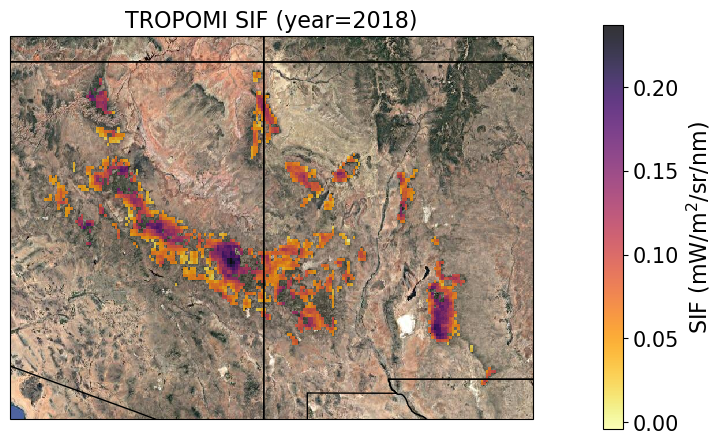

In [11]:
# Set up data array to plot
iregion = 0  # Southwest
min_dist = min_dists[iregion]
region_geom = region_geoms[iregion]
region_name = region_names[iregion]
xr_data_dict = {
    'SIF': TROPOMI_SIF_xr.rio.clip(region_geom.geometry, drop=True)
}
extent = [region_geom.total_bounds[0]-0.5, region_geom.total_bounds[2]+0.5, 
        region_geom.total_bounds[1]-0.5, region_geom.total_bounds[3]+0.5]
dat_da = xr_data_dict['SIF'].isel(year=0)
plot_min = np.nanmin(dat_da.values)
plot_max = np.nanmax(dat_da.values)

### Plot
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=(9, 7)) # establish the figure, axes
# Set extent of map before adding base img
ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=1) # Add base image

# add state boundaries to the map
ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)

dat_da.plot(ax=ax, transform=transform, alpha=alpha, 
                cmap='inferno_r', vmin = plot_min, vmax = plot_max,
                    cbar_kwargs={'orientation': 'vertical',
                                        'pad': 0.1,
                                        'label': r'SIF (mW/m$^2$/sr/nm)',
                                        'shrink': 0.75,
                                        'format': FFmt(z_axis_formatter)})

plt.title('TROPOMI SIF (year=2018)') # set axis title
plt.show()




### Divide grid into coarse pixels based on defined spatial lengthscale

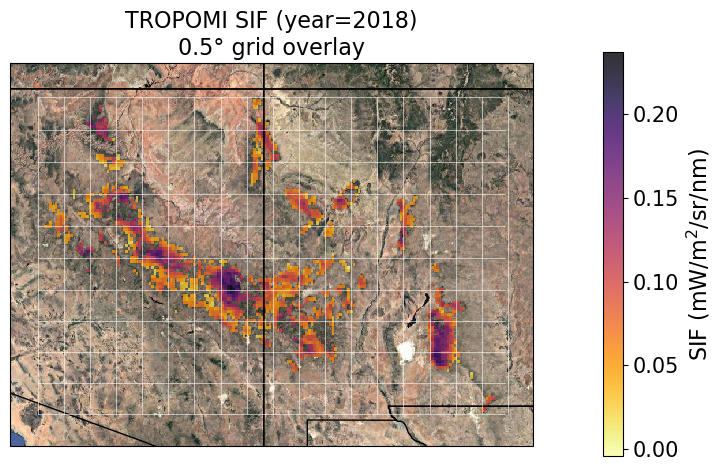

In [10]:
###################################
### Plot 2 - show gridded data on map but with coarse grid overlay
###################################

# Get grid cell boundaries
x_min, x_max = np.nanmin(dat_da.x), np.nanmax(dat_da.x)
y_min, y_max = np.nanmin(dat_da.y), np.nanmax(dat_da.y)

# Create grid cell boundaries
x_bins = np.arange(x_min, x_max + min_dist, min_dist)
y_bins = np.arange(y_min, y_max + min_dist, min_dist)


### Plot
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=(9, 7)) # establish the figure, axes
# Set extent of map before adding base img
ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=1) # Add base image

# add state boundaries to the map
ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)

# Plot vertical grid lines at x_bins
for x in x_bins:
    ax.plot([x, x], [y_min, y_max], color='white', linewidth=0.5, alpha=0.8, transform=ccrs.PlateCarree())

# Plot horizontal grid lines at y_bins
for y in y_bins:
    ax.plot([x_min, x_max], [y, y], color='white', linewidth=0.5, alpha=0.8, transform=ccrs.PlateCarree())
    
dat_da.plot(ax=ax, transform=transform, alpha=alpha, 
                cmap='inferno_r', vmin = plot_min, vmax = plot_max,
                    cbar_kwargs={'orientation': 'vertical',
                                        'pad': 0.1,
                                        'label': r'SIF (mW/m$^2$/sr/nm)',
                                        'shrink': 0.75,
                                        'format': FFmt(z_axis_formatter)})

plt.title(f'TROPOMI SIF (year=2018)\n{min_dist}° grid overlay') # set axis title
plt.show()


### Count number of pixels per coarse grid cell

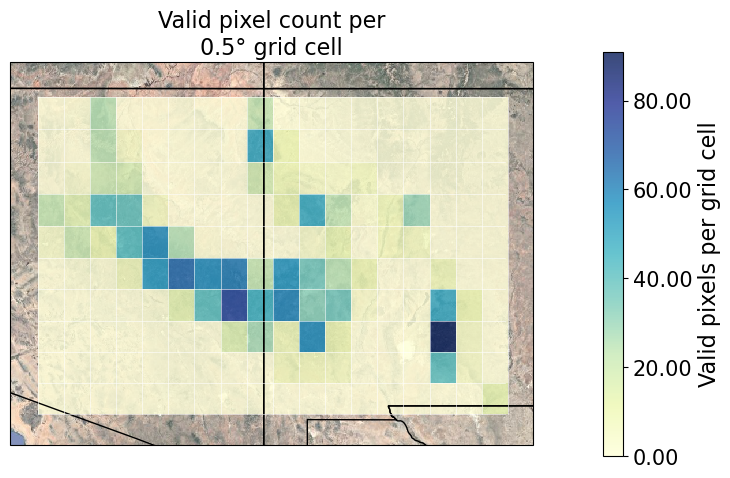

In [12]:
###################################
### Plot 3 - show count of valid datapoints per grid cell
###################################

# Create binary mask (1 for valid data, 0 for NaN)
dat_da_binary = xr.where(~np.isnan(dat_da), 1, 0)

# Assign each pixel to a grid cell and count valid pixels per cell
x_cell_indices = np.digitize(dat_da.x.values, x_bins) - 1
y_cell_indices = np.digitize(dat_da.y.values, y_bins) - 1

# Create new coordinate arrays for the coarse grid (cell centers)
x_cell_centers = (x_bins[:-1] + x_bins[1:]) / 2
y_cell_centers = (y_bins[:-1] + y_bins[1:]) / 2

# Initialize array to store counts per cell
n_x_cells = len(x_bins) - 1
n_y_cells = len(y_bins) - 1
cell_counts = np.zeros((n_y_cells, n_x_cells))

# Count valid pixels in each cell
for i, x_idx in enumerate(x_cell_indices):
    for j, y_idx in enumerate(y_cell_indices):
        if 0 <= x_idx < n_x_cells and 0 <= y_idx < n_y_cells:
            cell_counts[y_idx, x_idx] += dat_da_binary.values[j, i]

# Create new xarray DataArray with coarse grid
dat_da_grid_counts = xr.DataArray(
    cell_counts,
    coords={'y': y_cell_centers, 'x': x_cell_centers},
    dims=['y', 'x']
)
dat_da_grid_counts.rio.write_crs(4326, inplace=True)

# Plot the regridded data
plot_min_regrid = 0
plot_max_regrid = np.nanmax(cell_counts)

fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=(9, 7))
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=0.7)
ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)

# Plot vertical grid lines at x_bins
for x in x_bins:
    ax.plot([x, x], [y_min, y_max], color='white', linewidth=0.5, alpha=0.8, transform=ccrs.PlateCarree())

# Plot horizontal grid lines at y_bins
for y in y_bins:
    ax.plot([x_min, x_max], [y, y], color='white', linewidth=0.5, alpha=0.8, transform=ccrs.PlateCarree())

dat_da_grid_counts.plot(ax=ax, transform=transform, alpha=alpha, 
                cmap='YlGnBu', vmin=plot_min_regrid, vmax=plot_max_regrid,
                cbar_kwargs={'orientation': 'vertical',
                            'pad': 0.1,
                            'label': 'Valid pixels per grid cell',
                            'shrink': 0.75,
                            'format': FFmt(z_axis_formatter)})

plt.title(f'Valid pixel count per\n{min_dist}° grid cell')
plt.show()


### Express the counts in each coarse pixel as a probability
This probability represents the chance that in any given iteration of sampling, the randomly selected point within that coarse pixel will be retained in the set of regression model data

This is intended to keep the spatial distribution of sampled pixels un-biased, so that pixels in sparse forest areas are not overselected relative to pixels in dense forest areas

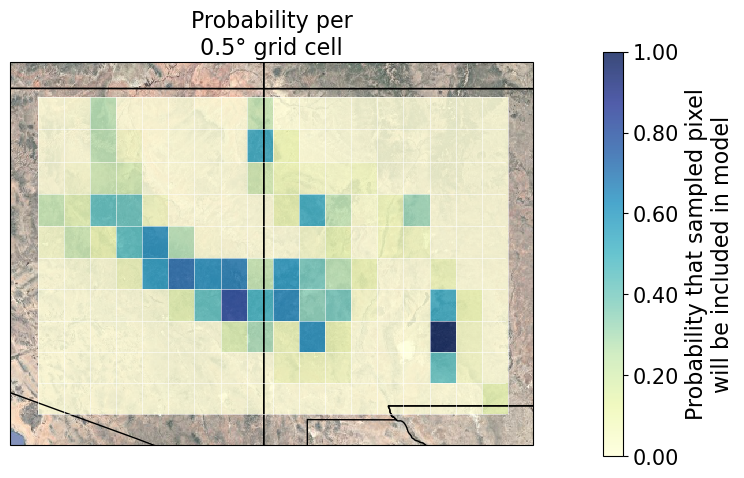

In [13]:
###################################
### Plot 4 - Convert count to probability of inclusion
###################################
max_grid_counts = np.nanmax(dat_da_grid_counts)
dat_da_grid_prob = dat_da_grid_counts / max_grid_counts
# Plot the regridded data
plot_min_regrid = 0
plot_max_regrid = np.nanmax(dat_da_grid_prob)

fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=(9, 7))
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=0.7)
ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)

# Plot vertical grid lines at x_bins
for x in x_bins:
    ax.plot([x, x], [y_min, y_max], color='white', linewidth=0.5, alpha=0.8, transform=ccrs.PlateCarree())

# Plot horizontal grid lines at y_bins
for y in y_bins:
    ax.plot([x_min, x_max], [y, y], color='white', linewidth=0.5, alpha=0.8, transform=ccrs.PlateCarree())

dat_da_grid_prob.plot(ax=ax, transform=transform, alpha=alpha, 
                cmap='YlGnBu', vmin=plot_min_regrid, vmax=plot_max_regrid,
                cbar_kwargs={'orientation': 'vertical',
                            'pad': 0.1,
                            'label': 'Probability that sampled pixel\nwill be included in model',
                            'shrink': 0.75,
                            'format': FFmt(z_axis_formatter)})

plt.title(f'Probability per\n{min_dist}° grid cell')
plt.show()


### Example of sampling procedure

Here are a few iterations of the sampling procedure in order to visualize how this works

Sampled 22 pixels from 1764 unique pixels.


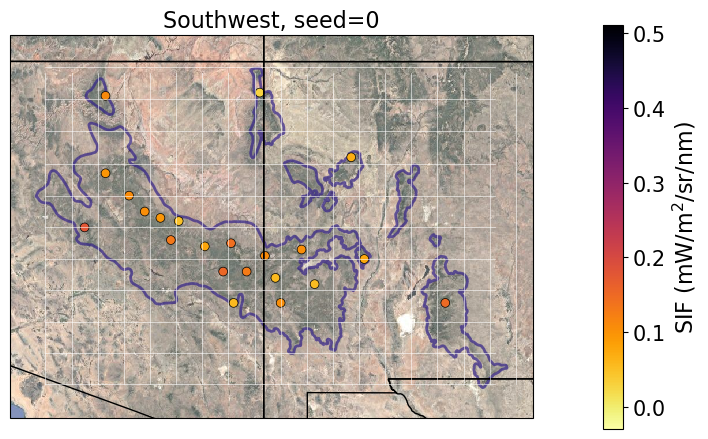

Sampled 25 pixels from 1764 unique pixels.


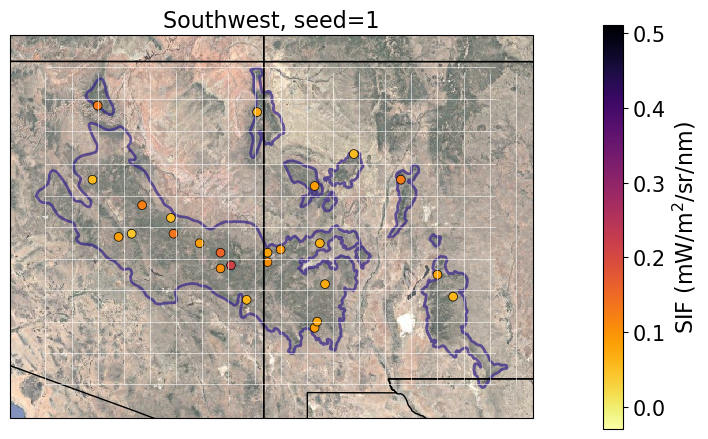

Sampled 22 pixels from 1764 unique pixels.


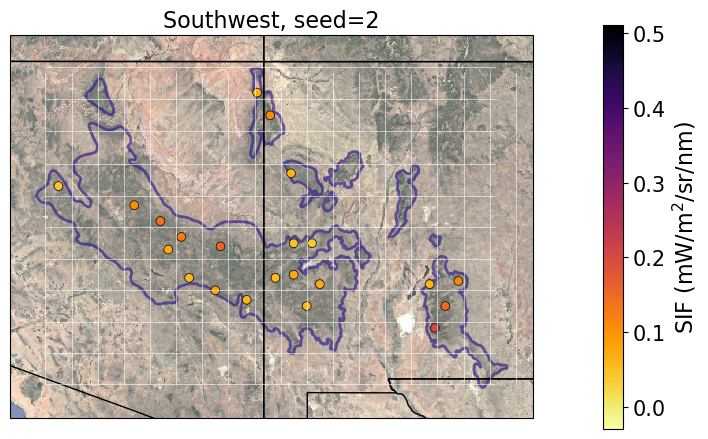

Sampled 27 pixels from 1764 unique pixels.


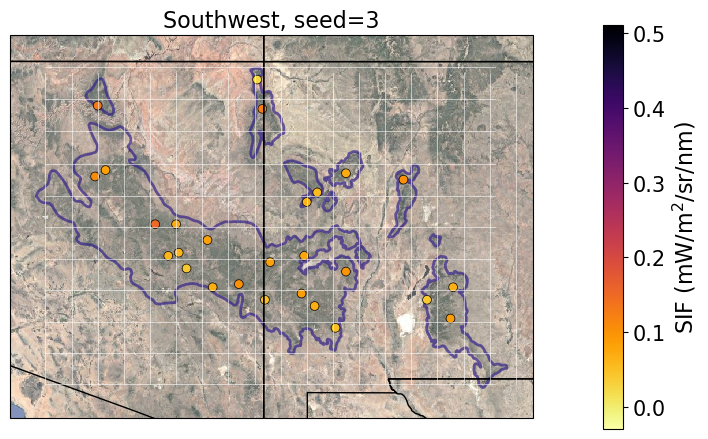

Sampled 21 pixels from 1764 unique pixels.


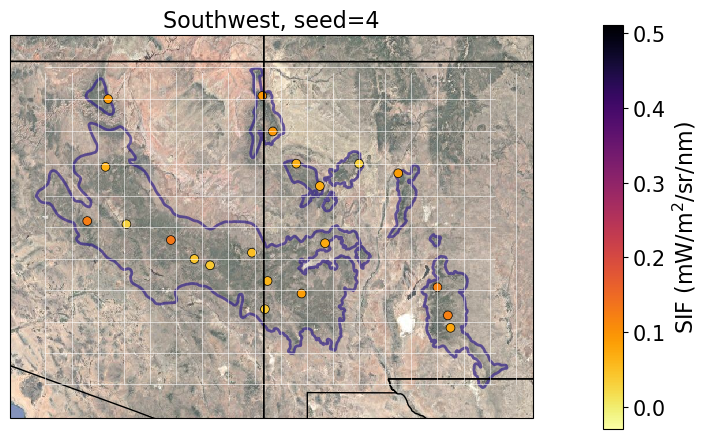

In [14]:

###################################
### Plot 5 - example iteration of probabilistic subsampling 
###################################

df_long = xarray_to_long_df(xr_data_dict, 'SIF')
key_vars = ['SIF']

# Add pixel_id, longitude, latitude
df_long['pixel_id'] = df_long['x'].astype(str) + '_' + df_long['y'].astype(str)
df_long['longitude'] = df_long['x']
df_long['latitude'] = df_long['y']

# Clean up - remove rows with missing values in key variables
df_model = df_long.dropna(subset=key_vars).copy()

# df_model contains one row per pixel-year (if time present). If you want to sample unique pixels only:
unique_pixels = df_model[['pixel_id', 'longitude', 'latitude']].drop_duplicates().reset_index(drop=True)

for iseed in range(5):

    sampled_pixels = spatial_subsample_grid_probabilistic(df_model,
                                                        spacing_deg=min_dist,
                                                        seed=iseed)

    # then filter your df_model to keep only sampled pixels (all years)
    df_model_sampled = df_model[df_model['pixel_id'].isin(sampled_pixels['pixel_id'])]

    # Get domain extent
    x_min, x_max = unique_pixels['longitude'].min(), unique_pixels['longitude'].max()
    y_min, y_max = unique_pixels['latitude'].min(), unique_pixels['latitude'].max()

    # Create grid cell boundaries
    x_bins = np.arange(x_min, x_max + min_dist, min_dist)
    y_bins = np.arange(y_min, y_max + min_dist, min_dist)

    # Filter for year = 2018
    df_2018 = df_model_sampled[df_model_sampled['year'] == 2018].copy()
    print(f"Sampled {len(df_2018)} pixels from {len(unique_pixels)} unique pixels.")
    extent = [region_geom.total_bounds[0]-0.5, region_geom.total_bounds[2]+0.5, 
            region_geom.total_bounds[1]-0.5, region_geom.total_bounds[3]+0.5]
    plotTitle = f'{region_name}, seed={iseed}'
    fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=(9, 7))
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=0.7)
    ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)
    ax.add_geometries(region_geom, crs=transform, facecolor='none', edgecolor='#332288', linewidth=2, zorder=1, alpha=0.7)

    # Plot vertical grid lines at x_bins
    for x in x_bins:
        ax.plot([x, x], [y_min, y_max], color='white', linewidth=0.5, alpha=0.8, transform=ccrs.PlateCarree())

    # Plot horizontal grid lines at y_bins
    for y in y_bins:
        ax.plot([x_min, x_max], [y, y], color='white', linewidth=0.5, alpha=0.8, transform=ccrs.PlateCarree())
    # Scatter plot of x, y colored by SIF
    sc = ax.scatter(
        df_2018['x'], df_2018['y'],
        c=df_2018['SIF'],
        cmap='inferno_r',
        vmin=np.nanmin(TROPOMI_SIF_xr.values),
        vmax=np.nanmax(TROPOMI_SIF_xr.values),
        s=40, edgecolor='black', linewidth=0.5,
        transform=ccrs.PlateCarree()
    )

    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.1, shrink=0.75)
    cbar.set_label(r'SIF (mW/m$^2$/sr/nm)')
    plt.title(plotTitle)
    plt.show()



### Sanity check - is pixel selection evenly distributed?

We will now run a simulation of 10,000 iterations of pixel sampling and we will track how many times each pixel gets sampled. The resuling plot will show the spatial distribution of this sampling frequency per pixel

Iteration 1 of 10000
Iteration 2 of 10000
Iteration 3 of 10000
Iteration 4 of 10000
Iteration 5 of 10000
Iteration 6 of 10000
Iteration 7 of 10000
Iteration 8 of 10000


Iteration 9 of 10000
Iteration 10 of 10000
Iteration 11 of 10000
Iteration 12 of 10000
Iteration 13 of 10000
Iteration 14 of 10000
Iteration 15 of 10000
Iteration 16 of 10000
Iteration 17 of 10000
Iteration 18 of 10000
Iteration 19 of 10000
Iteration 20 of 10000
Iteration 21 of 10000
Iteration 22 of 10000
Iteration 23 of 10000
Iteration 24 of 10000
Iteration 25 of 10000
Iteration 26 of 10000
Iteration 27 of 10000
Iteration 28 of 10000
Iteration 29 of 10000
Iteration 30 of 10000
Iteration 31 of 10000
Iteration 32 of 10000
Iteration 33 of 10000
Iteration 34 of 10000
Iteration 35 of 10000
Iteration 36 of 10000
Iteration 37 of 10000
Iteration 38 of 10000
Iteration 39 of 10000
Iteration 40 of 10000
Iteration 41 of 10000
Iteration 42 of 10000
Iteration 43 of 10000
Iteration 44 of 10000
Iteration 45 of 10000
Iteration 46 of 10000
Iteration 47 of 10000
Iteration 48 of 10000
Iteration 49 of 10000
Iteration 50 of 10000
Iteration 51 of 10000
Iteration 52 of 10000
Iteration 53 of 10000
Iteration 5

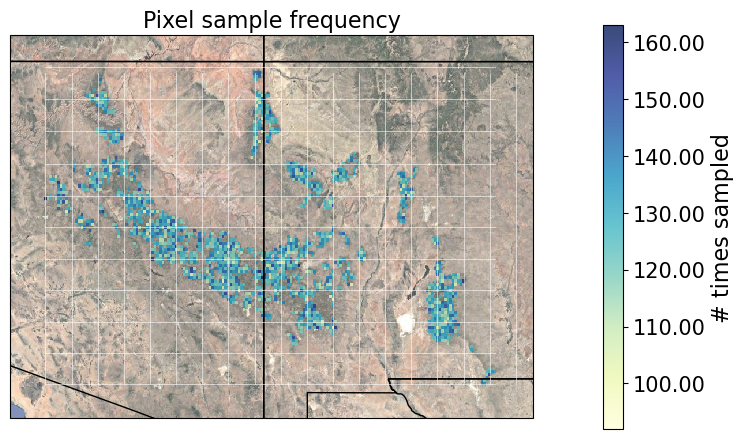

In [15]:

# Set up a blank grid (same resolution as TROPOMI SIF 0.05°)
count_da = dat_da.copy()
count_da = xr.where(~np.isnan(count_da), 0, count_da)
num_iter = 10000
for iseed in range(num_iter):
    print(f"Iteration {iseed+1} of {num_iter}")
    sampled_pixels = spatial_subsample_grid_probabilistic(df_model,
                                                        spacing_deg=min_dist,
                                                        seed=iseed)

    # then filter your df_model to keep only sampled pixels (all years)
    df_model_sampled = df_model[df_model['pixel_id'].isin(sampled_pixels['pixel_id'])]

    # Get domain extent
    x_min, x_max = unique_pixels['longitude'].min(), unique_pixels['longitude'].max()
    y_min, y_max = unique_pixels['latitude'].min(), unique_pixels['latitude'].max()

    # Create grid cell boundaries
    x_bins = np.arange(x_min, x_max + min_dist, min_dist)
    y_bins = np.arange(y_min, y_max + min_dist, min_dist)

    # Filter for year = 2018
    df_2018 = df_model_sampled[df_model_sampled['year'] == 2018].copy()

    # For each sampled pixel in df_2018, increment the corresponding grid cell in count_da
    for idx, row in df_2018.iterrows():
        # Find the closest grid cell in count_da and increment by 1
        count_da.loc[dict(y=row['y'], x=row['x'])] += 1


### Plot
plot_min = np.nanmin(count_da.values)
plot_max = np.nanmax(count_da.values)
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=(9, 7)) # establish the figure, axes
# Set extent of map before adding base img
ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=0.7) # Add base image

# add state boundaries to the map
ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)

# Plot vertical grid lines at x_bins
for x in x_bins:
    ax.plot([x, x], [y_min, y_max], color='white', linewidth=0.5, alpha=0.8, transform=ccrs.PlateCarree())

# Plot horizontal grid lines at y_bins
for y in y_bins:
    ax.plot([x_min, x_max], [y, y], color='white', linewidth=0.5, alpha=0.8, transform=ccrs.PlateCarree())
    
count_da.plot(ax=ax, transform=transform, alpha=alpha, 
                cmap='YlGnBu', vmin = plot_min, vmax = plot_max,
                    cbar_kwargs={'orientation': 'vertical',
                                        'pad': 0.1,
                                        'label': '# times sampled',
                                        'shrink': 0.75,
                                        'format': FFmt(z_axis_formatter)})

plt.title('Pixel sample frequency') # set axis title
plt.show()


#### ^Not perfect, but given that it's stochastic (i.e. wouldn't expect to be perfectly distributed) it's generally pretty good